# Transformer for speech command recognition

Ideas taken from `wav2vec2`, [arXiv:2006.11477 [cs.CL]](https://arxiv.org/abs/2006.11477)

## Configuration

Imports

In [1]:
import os
from collections import defaultdict
from io import BytesIO
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

load torchaudio:

In [2]:
import torchaudio
from torchaudio.datasets import SPEECHCOMMANDS

/home/aiserver/.virtualenvs/deeplearning/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


For audio output/recording in the notebook:

In [3]:
from ipywebrtc import CameraStream, AudioRecorder
from pydub import AudioSegment

Configuration

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", DEVICE)

device: cpu


/home/aiserver/.virtualenvs/deeplearning/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [5]:
MODEL_SAMPLE_RATE = 8000

BATCH_SIZE = 256
NUM_WORKERS = 4
EPOCHS = 20
LEARNING_RATE = 1e-2

SAVE_PATH = 'weights.pkl'

## Dataset

In [6]:
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.join(self._path, line.strip()) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

In [7]:
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

In [8]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))

In [9]:
print(labels)

['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


In [10]:
label2i = {labels[i]: i for i in range(len(labels))}

In [11]:
waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


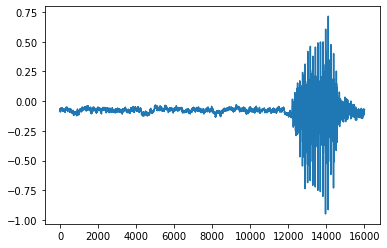

In [12]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

In [13]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

In [14]:
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=MODEL_SAMPLE_RATE)

In [15]:
transformed = transform(waveform)
ipd.Audio(transformed.numpy(), rate=MODEL_SAMPLE_RATE)

In [16]:
transform = transform.to(DEVICE)

### DataLoader

In [17]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)

In [18]:
def collate_fn(batch):
    tensors, targets = [], []

    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [torch.tensor(label2i[label])]

    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

In [19]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,
    collate_fn=collate_fn, num_workers=NUM_WORKERS, pin_memory=True)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False,
    collate_fn=collate_fn, num_workers=NUM_WORKERS, pin_memory=True)

## Model

In [20]:
class ModelConfig:
    input_dim = 1
    dim = 32
    mlp_dim = 128
    n_transformer_blocks = 8
    heads = 8
    feature_extractor_layers = [(10, 5)] + [(3, 2)] * 4
    pos_kernel_size = 65
    num_classes = len(labels)
    feature_extractor_p_drop = 0.1
    pos_p_drop = 0.1
    attn_p_drop = 0.1
    head_p_drop = 0.1
    
    def __init__(self, **kwargs):
        for k, v in kwargs.items():
            setattr(self, k, v)

### Feature Extractor

In [21]:
class TransposeLast(nn.Module):
    def forward(self, x):
        return x.transpose(-2, -1)

In [22]:
class ConvBlock(nn.Sequential):
    def __init__(self, input_dim, output_dim, kernel_size, stride, p_drop=0.):
        super().__init__(
            nn.Conv1d(input_dim, output_dim, kernel_size=kernel_size, stride=stride, bias=False),
            nn.Dropout(p_drop),
            TransposeLast(),
            nn.LayerNorm(output_dim),
            TransposeLast(),
            nn.GELU()
        )

In [23]:
class ConvFeatureExtractor(nn.Sequential):
    def __init__(self, cfg):
        dim = cfg.dim
        p_drop = cfg.feature_extractor_p_drop
        
        layers = []
        in_dim = cfg.input_dim
        for kernel_size, stride in cfg.feature_extractor_layers:
            layers.append(ConvBlock(in_dim, dim, kernel_size, stride, p_drop))
            in_dim = dim
        super().__init__(*layers)

### Transformer Encoder

In [24]:
class Residual(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.residual = nn.Sequential(*layers)
    
    def forward(self, x):
        return x + self.residual(x)

In [25]:
class FeedForward(nn.Sequential):
    def __init__(self, dim, hidden_dim, p_drop=0.):
        super().__init__(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(p_drop),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(p_drop)
        )

Attention:
$$
O=V\mathrm{softmax}\left(\frac{1}{\sqrt{c}}K^{\intercal}Q\right)\,,
$$
where $V,K,Q\in\mathbb{R}^{c\times n}$, $c$ is the number of channels, $n$ is the number of elements. Here $K^{\intercal}Q\in\mathbb{R}^{n\times n}$.

It is possible to use `torch.nn.MultiheadAttention`:

In [26]:
class SelfAttention(nn.Module):
    def __init__(self, dim, heads=8, p_drop=0.):
        super().__init__()
        self.heads = heads

        self.to_keys = nn.Linear(dim, dim)
        self.to_queries = nn.Linear(dim, dim)
        self.to_values = nn.Linear(dim, dim)
        self.unifyheads = nn.Linear(dim, dim)

        self.attn_drop = nn.Dropout(p_drop)
        self.resid_drop = nn.Dropout(p_drop)

    def forward(self, x):
        b, t, d = x.size()
        h, d_q = self.heads, d // self.heads

        keys = self.to_keys(x).view(b, t, h, d_q).transpose(1, 2) # move head forward to the batch dim
        queries = self.to_queries(x).view(b, t, h, d_q).transpose(1, 2)
        values = self.to_values(x).view(b, t, h, d_q).transpose(1, 2)

        att = queries @ keys.transpose(-2, -1)
        att = F.softmax(att * d_q**-0.5, dim=-1)
        att = self.attn_drop(att)
        
        out = att @ values
        out = out.transpose(1, 2).contiguous().view(b, t, d) # move head back
        out = self.unifyheads(out)
        out = self.resid_drop(out)
        return out

In [27]:
class Block(nn.Sequential):
    def __init__(self, dim, heads, mlp_dim, p_drop):
        super().__init__(
            Residual(nn.LayerNorm(dim), SelfAttention(dim, heads, p_drop)),
            Residual(nn.LayerNorm(dim), FeedForward(dim, mlp_dim, p_drop))
        )

In [28]:
class TransformerBlocks(nn.Sequential):
    def __init__(self, dim, depth, heads, mlp_dim, p_drop):
        layers = [Block(dim, heads, mlp_dim, p_drop) for _ in range(depth)]
        super().__init__(*layers)

In [29]:
class PositionEncoding(nn.Module):
    def __init__(self, dim, kernel_size, p_drop=0.):
        super().__init__()
        padding = (kernel_size - 1) // 2
        self.pos_conv = nn.Sequential(
            nn.Conv1d(dim, dim, kernel_size=kernel_size, padding=padding),
            nn.GELU()
        )
        self.dropout = nn.Dropout(p_drop)
    
    def forward(self, x):
        x = x + self.pos_conv(x)
        x = x.transpose(1, 2)
        x = self.dropout(x)
        return x

In [30]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, cfg):
        dim = cfg.dim
        super().__init__(
            PositionEncoding(dim, cfg.pos_kernel_size, cfg.pos_p_drop),
            TransformerBlocks(dim, cfg.n_transformer_blocks, cfg.heads, cfg.mlp_dim, cfg.attn_p_drop)
        )

### Classification Model

In [31]:
class Head(nn.Sequential):
    def __init__(self, dim, hidden_dim, num_classes, p_drop=0.):
        super().__init__(
            nn.LayerNorm(dim),
            TransposeLast(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(p_drop),
            nn.Linear(hidden_dim, num_classes)
        )

In [32]:
class MyModel(nn.Sequential):
    def __init__(self, cfg):
        super().__init__(
            ConvFeatureExtractor(cfg),
            TransformerEncoder(cfg),
            Head(cfg.dim, cfg.mlp_dim, cfg.num_classes, cfg.head_p_drop)
        )
        self.reset_parameters()
    
    def reset_parameters(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.02)
                if m.bias is not None: nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1.)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)
    
    def separate_parameters(self):
        # biases, and layernorm weights will not be decayed for regularization
        parameters_decay = set()
        parameters_no_decay = set()
        modules_weight_decay = (nn.Linear, nn.Conv1d)
        modules_no_weight_decay = (nn.LayerNorm, )
    
        for m_name, m in self.named_modules():
            for param_name, param in m.named_parameters():
                full_param_name = f"{m_name}.{param_name}" if m_name else param_name
                
                if isinstance(m, modules_no_weight_decay):
                    parameters_no_decay.add(full_param_name)
                elif param_name.endswith("bias"):
                    parameters_no_decay.add(full_param_name)
                elif isinstance(m, modules_weight_decay):
                    parameters_decay.add(full_param_name)

        return parameters_decay, parameters_no_decay

In [33]:
my_conf = ModelConfig()

In [34]:
model = MyModel(my_conf)
model.to(DEVICE);

In [35]:
n = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters:", n)

Number of parameters: 189955


## Training

### Training loop

In [84]:
def show_or_save(fig, filename=None):
    if filename:
        fig.savefig(filename, bbox_inches='tight', pad_inches=0.05)
        plt.close(fig)
    else:
        plt.show()

In [85]:
class History:
    def __init__(self):
        self.values = defaultdict(list)

    def append(self, key, value):
        self.values[key].append(value)

    def reset(self):
        for k in self.values.keys():
            self.values[k] = []

    def _plot(self, key, line_type='-', label=None):
        if not label: label=key
        xs = np.arange(1, len(self.values[key])+1)
        self.ax.plot(xs, self.values[key], line_type, label=label)

    def plot_train_val(self, key, x_is_batch=False, ylog=False, filename=None):
        fig = plt.figure()
        self.ax = fig.add_subplot(111)
        self._plot('train ' + key, '.-', 'train')
        self._plot('val ' + key, '.-', 'val')
        self.ax.legend()
        if ylog: self.ax.set_yscale('log')
        self.ax.set_xlabel('batch' if x_is_batch else 'epoch')
        self.ax.set_ylabel(key)
        show_or_save(fig, filename)

In [86]:
class Learner:
    def __init__(self, model, loss, optimizer, train_loader, val_loader, device,
                 transform, epoch_scheduler=None, batch_scheduler=None):
        self.model = model
        self.loss = loss
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.transform = transform
        self.epoch_scheduler = epoch_scheduler
        self.batch_scheduler = batch_scheduler
        self.history = History()
    
    
    def iterate(self, loader, msg="", backward_pass=False):
        total_loss = 0.0
        num_samples = 0
        num_correct = 0

        pbar = tqdm(enumerate(loader), total=len(loader))
        for it, (X, Y) in pbar:
            X, Y = X.to(self.device), Y.to(self.device)
            X = self.transform(X)
            Y_pred = self.model(X)
            batch_size = X.size(0)
            batch_loss = self.loss(Y_pred, Y)
            if backward_pass:
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                if self.batch_scheduler is not None:
                    self.batch_scheduler.step()
            
            total_loss += batch_size * batch_loss.item()
            num_samples += batch_size
            
            Y_pred.detach_() # conserve memory
            labels_pred = torch.argmax(Y_pred, -1)
            num_correct += (labels_pred == Y).sum()
            
            pbar.set_description("{} iter {}: loss {:.3f}, acc {:.3f}".format(
                msg, it, total_loss / num_samples, float(num_correct) / num_samples))
    
        avg_loss = total_loss / num_samples
        accuracy = float(num_correct) / num_samples
        return avg_loss, accuracy
    
    
    def train(self, msg):
        self.model.train()
        train_loss, train_acc = self.iterate(self.train_loader,  msg + ' train:', backward_pass=True)
        self.history.append('train loss', train_loss)
        self.history.append('train acc', train_acc)

        
    def validate(self, msg):
        self.model.eval()
        with torch.no_grad():
            val_loss, val_acc  = self.iterate(self.val_loader, msg + ' val:')
        self.history.append('val loss', val_loss)
        self.history.append('val acc', val_acc)


    def fit(self, epochs):
        for e in range(epochs):
            msg = f'epoch {e+1}/{epochs}'
            self.train(msg)
            self.validate(msg)
            if self.epoch_scheduler is not None:
                self.epoch_scheduler.step()

### Optimizer

In [87]:
def get_optimizer(model, learning_rate, weight_decay):
    param_dict = {pn: p for pn, p in model.named_parameters()}
    parameters_decay, parameters_no_decay = model.separate_parameters()
    
    optim_groups = [
        {"params": [param_dict[pn] for pn in parameters_decay], "weight_decay": weight_decay},
        {"params": [param_dict[pn] for pn in parameters_no_decay], "weight_decay": 0.0},
    ]
    optimizer = optim.AdamW(optim_groups, lr=learning_rate)
    return optimizer

In [88]:
optimizer = get_optimizer(model, learning_rate=3e-4, weight_decay=1e-2)

### Start Training

In [89]:
loss = nn.CrossEntropyLoss()

In [90]:
learner = Learner(model, loss, optimizer, train_loader, test_loader, DEVICE, transform)

In [91]:
EPOCHS = 20

In [92]:
learner.batch_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE,
                                                        steps_per_epoch=len(train_loader),
                                                        epochs=EPOCHS)

In [93]:
learner.fit(EPOCHS)

epoch 1/20 train: iter 331: loss 3.447, acc 0.049: 100%|██████████| 332/332 [01:32<00:00,  3.60it/s]
epoch 1/20 val: iter 42: loss 3.266, acc 0.085: 100%|██████████| 43/43 [00:03<00:00, 12.46it/s]
epoch 2/20 train: iter 331: loss 2.526, acc 0.259: 100%|██████████| 332/332 [01:32<00:00,  3.57it/s]
epoch 2/20 val: iter 42: loss 2.038, acc 0.405: 100%|██████████| 43/43 [00:03<00:00, 12.40it/s]
epoch 3/20 train: iter 331: loss 1.458, acc 0.558: 100%|██████████| 332/332 [01:33<00:00,  3.57it/s]
epoch 3/20 val: iter 42: loss 1.117, acc 0.668: 100%|██████████| 43/43 [00:03<00:00, 12.37it/s]
epoch 4/20 train: iter 331: loss 0.980, acc 0.708: 100%|██████████| 332/332 [01:33<00:00,  3.54it/s]
epoch 4/20 val: iter 42: loss 0.945, acc 0.728: 100%|██████████| 43/43 [00:03<00:00, 12.35it/s]
epoch 5/20 train: iter 331: loss 0.807, acc 0.756: 100%|██████████| 332/332 [01:33<00:00,  3.54it/s]
epoch 5/20 val: iter 42: loss 0.786, acc 0.774: 100%|██████████| 43/43 [00:03<00:00, 12.28it/s]
epoch 6/20 trai

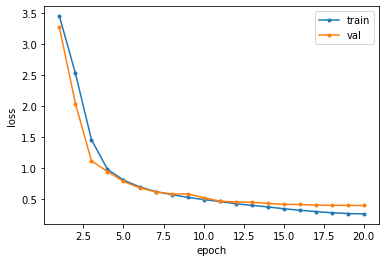

In [94]:
learner.history.plot_train_val('loss')

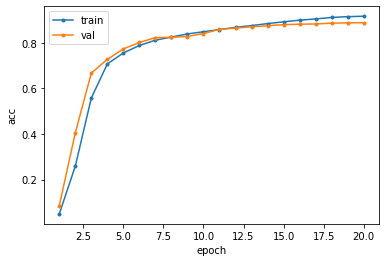

In [95]:
learner.history.plot_train_val('acc')

In [96]:
torch.save(model.state_dict(), SAVE_PATH)

## Testing

In [97]:
model.load_state_dict(torch.load(SAVE_PATH))

<All keys matched successfully>

In [98]:
model.eval();

In [99]:
def predict(waveform):
    waveform = waveform.to(DEVICE)
    waveform = transform(waveform)
    output = model(waveform.unsqueeze(0))
    pred_label_index = torch.argmax(output.squeeze(0), dim=-1)
    return labels[pred_label_index]

In [100]:
waveform, sample_rate, utterance, *_ = train_set[-1]
ipd.Audio(waveform.numpy(), rate=sample_rate)

In [101]:
print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

Expected: zero. Predicted: zero.


In [102]:
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):
    output = predict(waveform)
    if output != utterance:
        print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
        break
else:
    print("All examples in this dataset were correctly classified!")

ipd.Audio(waveform.numpy(), rate=sample_rate)

Data point #10. Expected: right. Predicted: eight.


Does not work in JupyterLab:

In [ ]:
camera = CameraStream(constraints={'audio': True,'video':False})
recorder = AudioRecorder(stream=camera)
recorder

In [52]:
recording = AudioSegment.from_file(BytesIO(recorder.audio.value))
recording = recording[0:1000]
recording = recording.set_frame_rate(16000)
recording.export("recording.wav", format="wav");

In [53]:
waveform, sample_rate = torchaudio.load("recording.wav")

In [ ]:
ipd.Audio(waveform.numpy(), rate=sample_rate)

In [ ]:
print(f"Predicted: {predict(waveform)}.")